# Cifar Library and Demo

[This is a library](https://pkg.go.dev/github.com/gomlx/gomlx/examples/cifar) to download and parse the Cifar datasets (Cifar-10 and Cifar-100), and a very small demo of a FNN (Feedforward Neural Network) with GoMLX. FNNs are notoriously bad for images, but it's only a demo. Look for the Resnet50 model for a more serious image classification model (old but still good -- best results as of the time of this writing is with ViT model).

The CIFAR-10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. See more details in [its homepage here](https://www.cs.toronto.edu/~kriz/cifar.html).

This notebook serves as documentation and example for the [github.com/gomlx/gomlx/examples/cifar](https://github.com/gomlx/gomlx/examples/cifar) library, and the demo code in one piece can be seen in [.../examples/cifar/demo/](https://github.com/gomlx/gomlx/tree/main/examples/cifar/demo)

## Environment Set Up

Let's set up `go.mod` to use the local copy of GoMLX, so it can be developed jointly the dataset code with the model. That's often how data pre-processing and model code is developed together with experimentation.

If you are not changing code, feel free to simply skip this cell. Or if you used a different directory for you projects, change it below.

Notice the directory `${HOME}/Projects/gomlx` is where the GoMLX code is copied by default in [its Docker](https://hub.docker.com/repository/docker/janpfeifer/gomlx_jupyterlab/general).

In [1]:
!*rm -f go.work && go work init && go work use . "${HOME}/Projects/gomlx"
%goworkfix

	- Added replace rule for module "github.com/gomlx/gomlx" to local directory "/home/janpf/Projects/gomlx".


## Data Preparation

### Downloading data files

To download, uncompress and untar to the local directory, simply do the following. Notice if it's already downloaded in the given `--data` directory, it returns immediately.

In [2]:
import (
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/pkg/support/fsutil"
    "github.com/janpfeifer/must"
)

var flagDataDir = flag.String("data", "~/work/cifar", "Directory to cache downloaded and generated dataset files.")

func AssertDownloaded() {
    *flagDataDir = must.M1(fsutil.ReplaceTildeInDir(*flagDataDir))
    if !fsutil.MustFileExists(*flagDataDir) {
        must.M(os.MkdirAll(*flagDataDir, 0777))
    }

    must.M(cifar.DownloadCifar10(*flagDataDir))
    must.M(cifar.DownloadCifar100(*flagDataDir))
}

%%
AssertDownloaded()

In [3]:
!ls -lh ~/work/cifar/

total 48K
drwxr-x--- 2 janpf janpf 4.0K Oct 10 17:53 base_cnn_model
drwxr-x--- 2 janpf janpf 4.0K Oct 10 17:52 base_fnn_model
drwxr-x--- 2 janpf janpf 4.0K Nov 12  2024 base_kan_model
drwxr-xr-x 2 janpf janpf 4.0K Jun  4  2009 cifar-10-batches-bin
drwxr-xr-x 2 janpf janpf 4.0K Feb 20  2010 cifar-100-binary
drwxr-x--- 2 janpf janpf 4.0K Aug  2  2024 cnn
drwxr-x--- 2 janpf janpf 4.0K Aug  1  2024 cnn_layer
drwxr-x--- 2 janpf janpf 4.0K Jul 31  2024 cnn_nonorm
drwxr-x--- 2 janpf janpf 4.0K Jul 31  2024 fnn_batchnorm_0
drwxr-x--- 2 janpf janpf 4.0K Aug  1  2024 fnn_layer
drwxr-x--- 2 janpf janpf 4.0K Nov 12  2024 kan
drwxr-x--- 2 janpf janpf 4.0K Nov 12  2024 r001


### Sample some images

The `cifar.NewDataset` creates a `data.InMemoryDataset` that can be used both for training, evaluation, or just to sample a few examples, which we do below:

Samples Cifar-10

truck ([9]),frog ([6]),horse ([7]),truck ([9]),dog ([5]),bird ([2]),frog ([6]),automobile ([1])

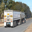
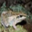
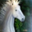
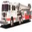
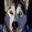
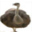
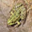
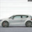

Samples Cifar-100

spider ([79]),lobster ([45]),hamster ([36]),trout ([91]),ray ([67]),bed ([5]),couch ([25]),bear ([3])

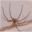
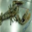
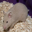
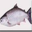
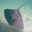
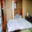
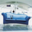
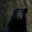

In [4]:
import (
    "strings"
    "github.com/gomlx/gopjrt/dtypes"
    "github.com/gomlx/gomlx/backends"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/pkg/core/shapes"
    "github.com/gomlx/gomlx/pkg/core/tensors/images"
    "github.com/janpfeifer/gonb/gonbui"

    _ "github.com/gomlx/gomlx/backends/default"
)

var (
    // Model DType, used everywhere.
    DType = dtypes.Float32
)

// sampleToNotebook generates a sample of Cifar-10 and Cifar-100 in a GoNB Jupyter Notebook.
func sampleToNotebook() {
    // Load data into tensors.
    backend := backends.MustNew()
    ds10 := cifar.NewDataset(backend, "Samples Cifar-10", *flagDataDir, cifar.C10, DType, cifar.Train).Shuffle()
    ds100 := cifar.NewDataset(backend, "Samples Cifar-100", *flagDataDir, cifar.C100, DType, cifar.Train).Shuffle()
    sampleImages(ds10, 8, cifar.C10Labels)
    sampleImages(ds100, 8, cifar.C100FineLabels)
}

// sampleTable generates and outputs one html table of samples, sampling rows x cols from the images/labels provided.
func sampleImages(ds train.Dataset, numImages int, labelNames []string) {
    gonbui.DisplayHTML(fmt.Sprintf("<p>%s</p>\n", ds.Name()))
    
    parts := make([]string, 0, numImages+5) // Leave last part empty.
    parts = append(parts, "<table><tr>")
    for ii := 0; ii < numImages; ii++ {
        _, inputs, labels := must.M3(ds.Yield())
        imgTensor := inputs[0]
        img := images.ToImage().Single(imgTensor)
        label := labels[0].Value().([]int64)
        labelStr := labelNames[label[0]]
    
        imgSrc := must.M1(gonbui.EmbedImageAsPNGSrc(img))
        size := imgTensor.Shape().Dimensions[0]
        parts = append(
            parts, 
            fmt.Sprintf(`<td><figure style="padding:4px;text-align: center;"><img width="%d" height="%d" src="%s">` + 
                        `<figcaption style="text-align: center;">%s (%d)</figcaption></figure></td>`, 
                        size*2, size*2, imgSrc, labelStr, label),
        )
    }
    parts = append(parts, "</tr></table>", "")
    gonbui.DisplayHTML(strings.Join(parts, "\n"))
}

%%
AssertDownloaded()
sampleToNotebook()

## Training on Cifar-10

### Models Support

1. `flagModel` defines the model type, out of `validModels` options.
1. `createDefaultContex` creates a context and set the default values for the CIFAR models. 
1. `contextFromSettings` uses `createDefaultContext` and incorporate changes passed by the `-set` flag.


In [5]:
import (
    "flags"
    
    "github.com/gomlx/gomlx/pkg/ml/layers"
    "github.com/gomlx/gomlx/pkg/ml/layers/fnn"
    "github.com/gomlx/gomlx/pkg/ml/layers/kan"
    "github.com/gomlx/gomlx/pkg/ml/layers/regularizers"
    "github.com/gomlx/gomlx/ui/commandline"
    "github.com/gomlx/gomlx/pkg/ml/train/optimizers"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/pkg/ml/context"
)

var (
    // ValidModels is the list of model types supported.
    ValidModels = []string{"fnn", "kan", "cnn"}
	flagEval      = flag.Bool("eval", true, "Whether to evaluate the model on the validation data in the end.")
	flagVerbosity = flag.Int("verbosity", 1, "Level of verbosity, the higher the more verbose.")
)

// settings is bound to a "-set" flag to be used to set context hyperparameters.
var settings = commandline.CreateContextSettingsFlag(createDefaultContext(), "set")

// createDefaultContext sets the context with default hyperparameters
func createDefaultContext() *context.Context {
	ctx := context.New()
	ctx.RngStateReset()
	ctx.SetParams(map[string]any{
        // Model type to use: valid values are fnn, kan and cnn.
		"model":           cifar.C10ValidModels[0],
		"checkpoint":      "",
		"num_checkpoints": 3,
		"train_steps":     3000,

		// batch_size for training.
		"batch_size": 64,

		// eval_batch_size can be larger than training, it's more efficient.
		"eval_batch_size": 200,

		// "plots" trigger generating intermediary eval data for plotting, and if running in GoNB, to actually
		// draw the plot with Plotly.
		plotly.ParamPlots: true,

		// If "normalization" is set, it overrides "fnn_normalization" and "cnn_normalization".
		layers.ParamNormalization: "none",

		optimizers.ParamOptimizer:           "adamw",
		optimizers.ParamLearningRate:        1e-4,
		optimizers.ParamAdamEpsilon:         1e-7,
		optimizers.ParamAdamDType:           "",
		activations.ParamActivation:         "swish",
		layers.ParamDropoutRate:             0.0,
		regularizers.ParamL2:                1e-5,
		regularizers.ParamL1:                1e-5,

		// FNN network parameters:
		fnn.ParamNumHiddenLayers: 8,
		fnn.ParamNumHiddenNodes:  128,
		fnn.ParamResidual:        true,
		fnn.ParamNormalization:   "",   // Set to none for no normalization, otherwise it falls back to layers.ParamNormalization.
		fnn.ParamDropoutRate:     -1.0, // Set to 0.0 for no dropout, otherwise it falls back to layers.ParamDropoutRate.

		// KAN network parameters:
		kan.ParamNumControlPoints:   10, // Number of control points
		kan.ParamNumHiddenNodes:     64,
		kan.ParamNumHiddenLayers:    4,
		kan.ParamBSplineDegree:      2,
		kan.ParamBSplineMagnitudeL1: 1e-5,
		kan.ParamBSplineMagnitudeL2: 0.0,
		kan.ParamDiscrete:           false,
		kan.ParamDiscreteSoftness:   0.1,
        kan.ParamResidual:           true,
	})
	return ctx
}

// ContextFromSettings is the default context (createDefaultContext) changed by -set flag.
func ContextFromSettings() (ctx *context.Context, paramsSet []string) {
    ctx = createDefaultContext()
    paramsSet = must.M1(commandline.ParseContextSettings(ctx, *settings))
    return
}

// Let's test that we can set hyperparameters by setting it in the "-set" flag:
%% -set="batch_size=17;fnn_num_hidden_layers=12"
fmt.Printf("Model types: %q\n", cifar.C10ValidModels)
ctx, parametersSet := ContextFromSettings()
fmt.Printf("Parameters set (-set): %q\n", parametersSet)
fmt.Println(commandline.SprintContextSettings(ctx))

Model types: ["fnn" "kan" "cnn"]
Parameters set (-set): ["batch_size" "fnn_num_hidden_layers"]
	"/activation": (string) swish
	"/adam_dtype": (string) 
	"/adam_epsilon": (float64) 1e-07
	"/batch_size": (int) 17
	"/checkpoint": (string) 
	"/dropout_rate": (float64) 0
	"/eval_batch_size": (int) 200
	"/fnn_dropout_rate": (float64) -1
	"/fnn_normalization": (string) 
	"/fnn_num_hidden_layers": (int) 12
	"/fnn_num_hidden_nodes": (int) 128
	"/fnn_residual": (bool) true
	"/kan_bspline_degree": (int) 2
	"/kan_bspline_magnitude_l1": (float64) 1e-05
	"/kan_bspline_magnitude_l2": (float64) 0
	"/kan_discrete": (bool) false
	"/kan_discrete_softness": (float64) 0.1
	"/kan_num_hidden_layers": (int) 4
	"/kan_num_hidden_nodes": (int) 64
	"/kan_num_points": (int) 10
	"/kan_residual": (bool) true
	"/l1_regularization": (float64) 1e-05
	"/l2_regularization": (float64) 1e-05
	"/learning_rate": (float64) 0.0001
	"/model": (string) fnn
	"/normalization": (string) none
	"/num_checkpoints": (int) 3
	"/optimize

### Simple FNN model

A trivial model, that can easily get to ~50% accuracy (a random model would do 10%), but hardly much more than that.

Later we are going to define a CNN model to compare, and we just set a placeholder model here for now.

> **Note**: 
>
> * The code is here just to exemplify. We are actually using the same code from the [`cifar`](https://github.com/gomlx/gomlx/tree/main/examples/cifar) package.

In [6]:
import (
    "flags"    
    . "github.com/gomlx/gomlx/pkg/core/graph"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/pkg/ml/context"
    "github.com/gomlx/gomlx/pkg/ml/train/optimizers"
    "github.com/gomlx/gomlx/pkg/core/shapes"
)

var _ = NewGraph  // Make sure the graph package is in use.

// C10PlainModelGraph implements train.ModelFn, and returns the logit Node, given the input image.
// It's a basic FNN (Feedforward Neural Network), so no convolutions. It is meant only as an example.
func C10PlainModelGraph(ctx *context.Context, spec any, inputs []*graph.Node) []*graph.Node {
    _ = spec  // Not needed, the input type is always the same.
	ctx = ctx.In("model")
	batchedImages := inputs[0]
	batchSize := batchedImages.Shape().Dimensions[0]
	logits := graph.Reshape(batchedImages, batchSize, -1)
	numClasses := len(cifar.C10Labels)
	modelType := context.GetParamOr(ctx, "model", cifar.C10ValidModels[0])
	if modelType == "kan" {
		// Configuration of the KAN layer(s) use the context hyperparameters.
		logits = kan.New(ctx, logits, numClasses).Done()
	} else {
		// Configuration of the FNN layer(s) use the context hyperparameters.
		logits = fnn.New(ctx, logits, numClasses).Done()
	}
	logits.AssertDims(batchSize, numClasses)
	return []*graph.Node{logits}
}

%% -set="batch_size=7"
// Let's test that the logits are coming out with the right shape: we want [batch_size, 10], since there are 10 classes.
AssertDownloaded()
ctx, _ := ContextFromSettings()
g := NewGraph(backends.MustNew(), "placeholder")
batchSize := context.GetParamOr(ctx, "batch_size", int(100))
logits := C10PlainModelGraph(ctx, nil, []*Node{Parameter(g, "images", shapes.Make(DType, batchSize, cifar.Height, cifar.Width, cifar.Depth))})
fmt.Printf("Logits shape for batch_size=%d: %s\n", batchSize, logits[0].Shape())

Logits shape for batch_size=7: (Float32)[7 10]


### Training Loop

With a model function defined, we use the training loop create for the Cifar10.

The trainer is provided in the [`cifar` package](https://github.com/gomlx/gomlx/tree/main/examples/cifar). It is straight forward (and almost the same for every different project) and does the following for us:

- If a checkpoing is given (--checkpoint) and it has previously saved model, it loads hyperparmeters and trained variables.
- Create trainer: with selected model function (see [Simple FNN model](#Simple-FNN-model) and [CNN model for Cifar10](#CNN-model-for-Cifar10) sections), optimizer, loss and metrics.
- Create a `train.Loop` and attach to it a progressbar, a periodic checkpoint saver and a plotter (`--set="plots=true"`).
- Train the selected number of train steps.
- Report results.

Below we train 50 steps with the default settings just to check things are working.

In [7]:
var flagCheckpoint = flag.String("checkpoint", "", "Directory save and load checkpoints from. If left empty, no checkpoints are created.")

// trainModel with hyperparameters configured with `-set=...`.
func trainModel() {
    ctx, paramsSet := ContextFromSettings()
    cifar.TrainCifar10Model(ctx, *flagDataDir, *flagCheckpoint, *flagEval, *flagVerbosity, paramsSet)
}

// Train 50 steps, only to test things are working. No plots.
%% --set="train_steps=50;plots=false"
trainModel()

Backend "stablehlo":	stablehlo:cuda - PJRT "cuda" plugin (/home/janpf/.local/lib/gomlx/pjrt/pjrt_c_api_cuda_plugin.so) v0.76 [StableHLO]
       100% [========================================] (2119 steps/s) [step=49] [loss+=2.45] [~loss+=3.05] [~loss=2.84] [~acc=16.91%]                
	[Step 50] median train step: 386 microseconds

Results on Validation:
	Mean Loss+Regularization (#loss+): 2.44
	Mean Loss (#loss): 2.23
	Mean Accuracy (#acc): 20.19%
Results on Training:
	Mean Loss+Regularization (#loss+): 2.44
	Mean Loss (#loss): 2.23
	Mean Accuracy (#acc): 19.72%


### FNN Model Training

Let's train the FNN for real this time. 

* **Note**: The FNN model quickly overfits to the data.

In [8]:
// Remove a previously trained model. Skip this if you want to continue training a previous model.
!rm -rf ~/work/cifar/base_fnn_model  

In [9]:
%% --checkpoint=base_fnn_model --set="model=fnn;train_steps=50_000;plots=true"
trainModel()

Backend "stablehlo":	stablehlo:cuda - PJRT "cuda" plugin (/home/janpf/.local/lib/gomlx/pjrt/pjrt_c_api_cuda_plugin.so) v0.76 [StableHLO]
Checkpointing model to "/home/janpf/work/cifar/base_fnn_model"


         1% [........................................] (391 steps/s) [0s:2m5s] [step=699] [loss+=1.93] [~loss+=1.98] [~loss=1.76] [~acc=36.94%]        

       100% [========================================] (2285 steps/s) [step=49999] [loss+=0.472] [~loss+=0.68] [~loss=0.454] [~acc=83.93%]        ]         


Metric: accuracy

Metric: loss

	[Step 50000] median train step: 343 microseconds

Results on Validation:
	Mean Loss+Regularization (#loss+): 2.37
	Mean Loss (#loss): 2.14
	Mean Accuracy (#acc): 50.64%
Results on Training:
	Mean Loss+Regularization (#loss+): 0.66
	Mean Loss (#loss): 0.434
	Mean Accuracy (#acc): 84.96%


### CNN model for Cifar-10

Let's now properly define a CNN model to compare.

The model was built following a [Keras model in Kaggle (thanks @ektasharm)](https://www.kaggle.com/code/ektasharma/simple-cifar10-cnn-keras-code-with-88-accuracy),
which provided hardcoded values for all layers of the model -- so it doesn't make use of the hyperparamters set in the context. It achieves \~86% on the validation set, after 80,000 steps of batch size 64 (\~100 epochs).

Notice that since it uses batch normalization, the training process will, at the end, update the moving averages of mean and variance: this improves the running estimate the model keeps during training. This [interesting blog post](https://www.mindee.com/blog/batch-normalization) explains about it. 

In [10]:
// ConvolutionModelGraph implements train.ModelFn and returns the logit Node, given the input image.
// It's a straight forward CNN (Convolution Neural Network) model.
//
// This is modeled after the Keras example in Kaggle:
// https://www.kaggle.com/code/ektasharma/simple-cifar10-cnn-keras-code-with-88-accuracy
// (Thanks @ektasharma)
func ConvolutionModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
	ctx = ctx.In("model")
	batchedImages := inputs[0]
	g := batchedImages.Graph()
	dtype := batchedImages.DType()
	batchSize := batchedImages.Shape().Dimensions[0]
	logits := batchedImages

	layerIdx := 0
	nextCtx := func(name string) *context.Context {
		newCtx := ctx.Inf("%03d_%s", layerIdx, name)
		layerIdx++
		return newCtx
	}

	logits = layers.Convolution(nextCtx("conv"), logits).Filters(32).KernelSize(3).PadSame().Done()
	logits.AssertDims(batchSize, 32, 32, 32)
	logits = activations.Relu(logits)
	logits = batchnorm.New(nextCtx("batchnorm"), logits, -1).Done()
	logits = layers.Convolution(nextCtx("conv"), logits).Filters(32).KernelSize(3).PadSame().Done()
	logits = activations.Relu(logits)
	logits = batchnorm.New(nextCtx("batchnorm"), logits, -1).Done()
	logits = MaxPool(logits).Window(2).Done()
	logits = layers.DropoutNormalize(nextCtx("dropout"), logits, Scalar(g, dtype, 0.3), true)
	logits.AssertDims(batchSize, 16, 16, 32)

	logits = layers.Convolution(nextCtx("conv"), logits).Filters(64).KernelSize(3).PadSame().Done()
	logits.AssertDims(batchSize, 16, 16, 64)
	logits = activations.Relu(logits)
	logits = batchnorm.New(nextCtx("batchnorm"), logits, -1).Done()
	logits = layers.Convolution(nextCtx("conv"), logits).Filters(64).KernelSize(3).PadSame().Done()
	logits.AssertDims(batchSize, 16, 16, 64)
	logits = activations.Relu(logits)
	logits = batchnorm.New(nextCtx("batchnorm"), logits, -1).Done()
	logits = MaxPool(logits).Window(2).Done()
	logits = layers.DropoutNormalize(nextCtx("dropout"), logits, Scalar(g, dtype, 0.5), true)
	logits.AssertDims(batchSize, 8, 8, 64)

	logits = layers.Convolution(nextCtx("conv"), logits).Filters(128).KernelSize(3).PadSame().Done()
	logits.AssertDims(batchSize, 8, 8, 128)
	logits = activations.Relu(logits)
	logits = batchnorm.New(nextCtx("batchnorm"), logits, -1).Done()
	logits = layers.Convolution(nextCtx("conv"), logits).Filters(128).KernelSize(3).PadSame().Done()
	logits.AssertDims(batchSize, 8, 8, 128)
	logits = activations.Relu(logits)
	logits = batchnorm.New(nextCtx("batchnorm"), logits, -1).Done()
	logits = MaxPool(logits).Window(2).Done()
	logits = layers.DropoutNormalize(nextCtx("dropout"), logits, Scalar(g, dtype, 0.5), true)
	logits.AssertDims(batchSize, 4, 4, 128)

	// Flatten logits, and we can use the usual FNN/KAN.
	logits = Reshape(logits, batchSize, -1)
	logits = layers.Dense(nextCtx("dense"), logits, true, 128)
	logits = activations.Relu(logits)
	logits = batchnorm.New(nextCtx("batchnorm"), logits, -1).Done()
	logits = layers.DropoutNormalize(nextCtx("dropout"), logits, Scalar(g, dtype, 0.5), true)
	numClasses := len(cifar.C10Labels)
	logits = layers.Dense(nextCtx("dense"), logits, true, numClasses)
	return []*Node{logits}
}

%% -set="batch_size=11"
// Let's test that the logits are coming out with the right shape: we want [batch_size, 10], since there are 10 classes.
AssertDownloaded()
ctx, _ := ContextFromSettings()
g := NewGraph(backends.MustNew(), "placeholder")
batchSize := context.GetParamOr(ctx, "batch_size", int(100))
logits := ConvolutionModelGraph(ctx, nil, []*Node{Parameter(g, "images", shapes.Make(DType, batchSize, cifar.Height, cifar.Width, cifar.Depth))})
fmt.Printf("Logits shape for batch_size=%d: %s\n", batchSize, logits[0].Shape())


Logits shape for batch_size=11: (Float32)[11 10]


### Training the CNN model

CNNs have a much better inductive bias for machine learning on images, and it can easily achieve > 80% accuracy in training data, and some less on validation data, due to overfitting.

Likely it would benefit from pre-training the model on a larger unlabeled datasets -- see the "Dogs vs Cats" example to see transfer learning in action for an image model.

In [11]:
!rm -rf ~/work/cifar/base_cnn_model

In [12]:
%% --checkpoint=base_cnn_model --set="model=cnn;learning_rate=1e-3;l2_regularization=0;l1_regularization=0;train_steps=80000"
trainModel()

Backend "stablehlo":	stablehlo:cuda - PJRT "cuda" plugin (/home/janpf/.local/lib/gomlx/pjrt/pjrt_c_api_cuda_plugin.so) v0.76 [StableHLO]
Checkpointing model to "/home/janpf/work/cifar/base_cnn_model"


         0% [........................................] (517 steps/s) [1s:2m33s] [step=719] [loss+=1.66] [~loss+=1.67] [~loss=1.67] [~acc=37.29%]        

       100% [========================================] (969 steps/s) [step=79999] [loss+=0.822] [~loss+=0.63] [~loss=0.63] [~acc=78.56%]        28%]          


Metric: accuracy

Metric: loss

	[Step 80000] median train step: 916 microseconds

Results on Validation:
	Mean Loss+Regularization (#loss+): 0.576
	Mean Loss (#loss): 0.576
	Mean Accuracy (#acc): 80.90%
Results on Training:
	Mean Loss+Regularization (#loss+): 0.376
	Mean Loss (#loss): 0.376
	Mean Accuracy (#acc): 86.75%


## Inference

Inference, or serving the model, is done by using the same code as used to train the model.
That is, currently the way to save the model is to export the Go model creation function, along with the checkpoint with learned weights.

We created a small library `cifar/classifier` that takes an image as input, convert it to a tensor and calls the trained model


Image: (32 x 32)

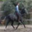

Class: horse (7)

In [13]:
import (
    "encoding/base64"
    "image/png"
    
    "github.com/gomlx/gomlx/examples/cifar/classifier"
    // We also must import then engine that will execute the model.
    // Currently only XLA is supported.
    _ "github.com/gomlx/gomlx/backends/default"
)

%%
// Decode and print PNG image.
imgBase64 := bytes.NewBufferString(
    "iVBORw0KGgoAAAANSUhEUgAAACAAAAAgCAIAAAD8GO2jAAAI5UlEQVR4nCxWSZMc1dV988upMmvo6uqWWvrUgFDwGWEMAZhwEAZ7YXvrrX+CN1765+GVg43DCwIhbAdCotVTVeX88o33OarxWWfcOPnuGS77458+Q4xWy0U1r7wF75CZIEaOEUUIDcNQ1zWlNIBnjAYIR0dHi9VKTZr5iAMYBEJKjpCx02azmi/mVrtJaWttjLGc5WyVPAwYUc1FWFo3OuMRIt4CISgEO01T13Xeey54VVVlXiUsGXZtbxSO2Acvi9wo58dJqR7jQCjBETvnxnFUatrvt+ze8SOPgAkZMFijjI7WGIxpWeYyyX3wp6enXdcpbTCi3gTlh7Efsipbnhw5FLU1hUwV4DxPEMa73Y5i2rUDAHDO0zRjxTw/TMWx67px1M55732aJsYq65AQAgAwxk3TqVFvqoVHlAG8tb7nGL1otlab0werfC26vhGCpFnS1v00TTHGIs+r+Zw5ZExQ+6692e66znjviiIDIEoF57yU0vsAENNE1tt9GHTGkv9/6+2TxfHXL//VDQ1F5NWLl6v1ilJKCBFCIjTEiBjn5XzBOCdmckM/9Z1q26FpGoyJ9zBNpm0H52A+X3KeVOX8yfnDk9W8HdX8wfkHX/z+P5fbq6axMWDOt7vm6nKbJrM0LTHiQqSE8ojZvu2ud3vGuXDWq1FBgKIoZrNZCMFab61zzl9dXRNCnPOJkKcPz4NY/fKLP3zy+e+e/fMfTT/gFCOHY8RdNxjtACBCZIzneaGN2W13CCHW32FUIwAImXjvrbV3+0kRQtbasiwRQsoBYunx2fGgyYvXzRSinkxCeKCwXK5RjJeXN3mRZJls+65rO8EYBrRarch2ux3GASEUY0QIOXcg4r03+gBKKQAYY6xz2tim7V+8uLq57SxCRrv2tnHa+RDrup2UybNZ2w510xymeZCUIetYjHD3JtYYmxclQhhhhCKCGKdpAgCtdZ7nszIbVJhUNKO22iXFzFrnxyEC3e46PaknTx5vNqfW2n1XV/OKuIC073c7+vS9pz4AIgRjioE7G4zWd/SnEBzGiDGWSJ6nSSJTpT0iPMuzJCFGjRSR4EPbDYQy66wQsppXMYLTJjpPIDKC6Re/+e3q6LgoyxiIVbFv+6Ht1DCg6DECKXmepcH7u5cjL1/92PZ7jIMU+e3tHkFs673RBlHmnEsSWVYlAdTtmuAsZ0xKwYw2Zhh7ddDo0I6jGkMwjBFKCKOcYu7twZMR0/2ujtqCMeryqmWcU7IfBmsdwXgaRylZs9+1y/J0vTbjkCVilsk8TVj0h8QZ+8EZbf0Qo8UkMk6dA8Z5kc8PciIkUjpNbc6kHVWom5rhPE8XVdnvbiilpeSr1YJitLu+miUcYVBqEBQQOPr+06eT1sZo66zzh6AIHsVI8qzcbO4vl2uCGaUiIIIxAeNU01qtgEQEQRz+lKVSSEE5p3kmrZmGoevapqn3nGHOKBv7wXsPHhgmgifWxBABxwRFMQ6aURXv9Cvy9PTk/qWDtqmbtvENkpzYg9igH3pGQAoavJvUMIxBCi45JQQRghiR0gfoxskHiIitlqdt21tjtzdbNYyJkPTgZEcJdoTM8kwfLfuhmYYGryrOBCMoOQzzlCEpudYMvMMEECYBRxM8sQhdbbej0s5BkhTL5TocXKa8NUZNzXan+sFpjazptrcMoaPFIhUSeevN5K1eVLN79zZpLiY9dn0XABjjANH64AFjJpkZVfSO4sAoWVV5V98EZ4TgEMIwdgHc5vgYIeTDwRllWXIuAnhKKcYYIjjns0LM0CzLMn8HSuSkpjxPpJilScmCtlWaQsJWq2VRyLa+KQoJmEUUrFHD0GIMaZomqdjttk27n81m3tsqz7xzwzBmARWzo7IsASBJkhijFKm1Xggxn8+rcsaIhypL15t7y0X546sLisysSPvpwCWAizF0XTOOfV6kITgAb8xkjd4s5oSQpm4Q5ofgskoIwRhPEqmUgkOBCwBr3UTPVieUACPBWbXf3gBCiPB+0sPQoxhmZRERaDMJwU5PT4TkxugQfJ5lj99+ks/Kru+l5HW7k1IeAt7am9vX1zcX1ukAVqmeea9PVuuEQd/U2mqgiXa2GYaA/HozJ4RhErWZ8jJbHi+MMUmRQADwcFnfzBdL0bBtty3nM0cRZoCJK2a5dwaCF+yQpPTs3oYSoNHXTV0rjXliPLSjWi7K9apKk1SNkxrV6f2TYpYTSmMEhOKuri9eXxCKN5u1sdrYgy4IBs5JdAGFKIVMZJImKauOl5PXHBFeljISQqgzapYmp+t1Kgmj4ofvX2VptqzmyEPCeVrN67qOzj16cHa0WHCC33njzZffv8wR3SyP8iyJER0aUErOOaGUHW+OIvhU8izJqm6ajDXu8vH9B5vjlRCEUYmBfPfdv9948H/r9YoQIqV89uxZSunHn3xSzmbGmkzmD49Ov33+za8+/DjNJMKE/CRiAIQR++C9pygiQinngrP0xQ8/YEQ+//VnAD7EkMjs/Xd/8eWXf9vfbD96/+eUsn29d2r69KMP33v3Z9aarusikOLRo+fPv7m4uDg/f5im+U91K4TgnNO//uXP82qxXh1V1XK9Ptnebpfz6s3zc++sPHwiBePHR+tn33w9tF2WpV/9/SvB2aeffoQjaD3dbRIhQrWZur6hjNX7elJ6HIbt7c4YyyLCnDGEMYlYj8N6udA6ubi4MEYLISnVAA0h5PHbbzVte7PbdePw7vk7r68ujdGMHXomIpSm+f2zY4AgBItAnAdt7Diqvh/Zt8+/i3fAmNT7drFYtm3b9/2dJw8NhTEehgFhRBm9eH3x4OEDLuT1zbUxuqrmVVUyxjFGhHBKJaVM8JySO/cZjzFhXdcZY0IIMaLXF9fX1zdFUQghQggBwkEwMVprXfBZli2XyyRJtJ44EwRTSph3gWCGCfYu6EkbY+dzRDBTSmGMhBSMMfa/jUd8dnYWQqCUpmn604Hkvc/zXEoJKBZFcTiQlOIHylQIPJ9XhJAYo1JKa51lWTnLrLHWqjzPGWPe+/8GAAD//7swHNFia9prAAAAAElFTkSuQmCC")
imgPNG := must.M1(io.ReadAll(base64.NewDecoder(base64.StdEncoding, imgBase64)))
img := must.M1(png.Decode(bytes.NewBuffer(imgPNG)))
size := img.Bounds()
gonbui.DisplayHTML(fmt.Sprintf("<p>Image: (%d x %d)</p>", size.Dx(), size.Dy()))
gonbui.DisplayPNG(imgPNG)

// Classify:
c10Classifier := must.M1(classifier.New("~/work/cifar/base_fnn_model"))
classID := must.M1(c10Classifier.Classify(img))
className := cifar.C10Labels[classID]
gonbui.DisplayHTML(fmt.Sprintf("<p>Class: <b>%s (%d)</b></p>", className, classID))

### Generate a random image as base64


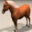

In [15]:
// 
%%
backend := backends.MustNew()
ds := cifar.NewDataset(backend, "Samples Cifar-10", *flagDataDir, cifar.C10, DType, cifar.Train).Shuffle()
_, inputs, _ := must.M3(ds.Yield())
imgTensor := inputs[0]
img := images.ToImage().Single(imgTensor)
imgSrc := must.M1(gonbui.EmbedImageAsPNGSrc(img))
// imgBase64 := imgSrc[22:]  // Strip the preamble for a <img> src tag.
// fmt.Printf("%s\n\n", imgBase64)
size := imgTensor.Shape().Dimensions[0]
gonbui.DisplayHTML(fmt.Sprintf(`<img width="%d" height="%d" src="%s"/>`, size*2, size*2, imgSrc))